# Preprocess tracks from PostgreSQL

In [ ]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel

pandarallel.initialize()
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
raw_dataset = pd.read_csv("data/12_02_2021.csv")
raw_dataset.head()

In [ ]:
def process_df(df):

    lats = df.lats
    lats = lats[1:-1].split(',')
    df.lats = np.array(lats).astype(np.float32)

    lngs = df.lngs
    lngs = lngs[1:-1].split(',')
    df.lngs = np.array(lngs).astype(np.float32)

    speeds = df.speeds
    speeds = speeds[1:-1].split(',')
    df.speeds = np.array(speeds).astype(np.uint8)

    direction = df.direction
    direction = direction[1:-1].split(',')
    df.direction = np.array(direction).astype(np.uint8)

    ts = df.ts
    ts = ts[1:-1].split(',')
    df.ts = np.array(ts).astype(np.uint)

    return df

In [ ]:
dataset = raw_dataset.parallel_apply(process_df, axis=1)

In [ ]:
dataset.head()
# https://github.com/jmcarpenter2/swifter/

In [ ]:
# dataset.to_csv('data/preprocessed_dataset.csv')

# Split to small tracks

In [ ]:
import pandas as pd
import numpy as np
import geopy.distance as distance

In [ ]:
def split_tracks(df):
    splitted_tracks = []
    
    speeds = df.speeds[::-1]
    ts = df.ts[::-1]
    lats = df.lats[::-1]
    lons = df.lngs[::-1]

    prev_start = 0
    dist = 0
    for i in range(1, len(lats)):
        new_dist = distance.great_circle( (lats[i-1], lons[i-1]), (lats[i], lons[i]) ).km
        
        if (dist + new_dist) < 2:
            dist += new_dist
            continue
        
        track = [ lats[prev_start:i], lons[prev_start:i], ts[prev_start:i], speeds[prev_start:i], dist*1000, i - prev_start ]
        prev_start = i
        dist = 0
        
        splitted_tracks.append(track)
        
    return pd.DataFrame(splitted_tracks)

In [ ]:
split_dataset = dataset.parallel_apply(split_tracks, axis=1)

In [ ]:
corrected_dataset = pd.concat(split_dataset.to_list())

In [ ]:
corrected_dataset.head()

In [ ]:
corrected_dataset.to_csv("data/processed_tracks.csv")

In [ ]:
import pickle as pkl
import os

In [ ]:
path = "/home/rami/Desktop/sd_maps/routing/collected_ds"

In [ ]:
os.listdir(path)

In [ ]:
with open(os.path.join(path, "train-data_2020-09-19T17:21:56.972509.pkl"), 'rb') as fname :
    train_data = pkl.load(fname)

In [ ]:
pd.DataFrame(train_data).head()

# Old RFR approach

In [180]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pickle as pkl

import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


import os
dir_name = "/home/rami/Desktop/sd_maps/routing/collected_ds"

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
rcParams["errorbar.capsize"] = 5

In [181]:
osrm_error = []
pred_error = []

osrm_std = []
pred_std = []

full_train_data = []
full_labels = pd.DataFrame(columns=["ya_dur", "osrm_dur", "dist"])

timestamps = []
ts_labels = []
fnames = os.listdir(dir_name)
fnames.sort()
for name in fnames:
    if name[-3:] != "csv":
        with open(os.path.join(dir_name, name), "rb") as f:
            full_train_data.extend(pkl.load(f))
        continue
    
    labels = pd.read_csv(os.path.join(dir_name, name))
    osrm_error.append(np.mean(labels.ya_dur - labels.osrm_dur))
    osrm_std.append(np.std(labels.ya_dur - labels.osrm_dur))
    
    pred_error.append(np.mean(labels.ya_dur - labels.pred))
    pred_std.append(np.std(labels.ya_dur - labels.pred))
    
    ts_srt = name[:-4]
    ts_srt = ts_srt.split("_")[1]
    ts = datetime.strptime(ts_srt, '%Y-%m-%dT%H:%M:%S.%f')
    # timestamps.append( f"{ts.day}.{ts.month} {ts.hour}:{ts.minute}" )
    timestamps.append(datetime.strptime(ts_srt, '%Y-%m-%dT%H:%M:%S.%f'))
    ts_labels.append( f"{ts.day}.{ts.month} {ts.hour}:{ts.minute}" )
    labels["hour"] = [ts.hour] * len(labels)
    
    full_labels = full_labels.append( labels[["ya_dur", "osrm_dur", "dist", "hour"]], ignore_index=1 )
    
stats = pd.DataFrame( {"osrm_error": osrm_error, "osrm_std": osrm_std, "pred_error": pred_error, "pred_std": pred_std, "timestamp": timestamps, "ts_labels": ts_labels} )
stats = stats.sort_values("timestamp")

#with open("full_data_regr.pkl", "rb") as f:
#    regressor = pkl.load(f)

#with open("rfr_mb_nice.pkl", "rb") as f:
#    old_regressor = pkl.load(f)
    
#full_labels["new_regr_pred"] = regressor.predict(full_train_data)
#full_labels["old_pred"] = old_regressor.predict(full_train_data)

In [182]:
full_labels

,ya_dur,osrm_dur,dist,hour
0,41.561933,35.213333,31.489,21.0
1,51.455894,53.161667,58.064,21.0
2,45.824583,42.710000,49.139,21.0
3,19.408894,7.653333,5.306,21.0
4,34.550419,32.640000,39.779,21.0
...,...,...,...,...
147986,46.248957,43.398333,51.410,17.0
147987,53.369956,52.823333,64.818,17.0
147988,45.173141,41.486667,52.569,17.0
147989,34.569927,24.561667,17.074,17.0


In [183]:
X = pd.DataFrame(data=full_train_data, columns=["osrm", "distance", "n_slow", "n_medium", "n_fast", "n_free"])
X["hour"] = full_labels.hour.to_numpy()
del full_labels["hour"]
X

,osrm,distance,n_slow,n_medium,n_fast,n_free,hour
0,35.213333,31.489,0,5,13,20,21.0
1,53.161667,58.064,0,13,12,17,21.0
2,42.710000,49.139,1,8,2,42,21.0
3,7.653333,5.306,0,6,5,4,21.0
4,32.640000,39.779,1,9,6,71,21.0
...,...,...,...,...,...,...,...
147986,43.398333,51.410,2,7,5,38,17.0
147987,52.823333,64.818,0,3,3,13,17.0
147988,41.486667,52.569,2,4,14,101,17.0
147989,24.561667,17.074,1,21,21,11,17.0


In [184]:
dataset = pd.concat([full_labels, X], axis=1)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, dataset["ya_dur"], test_size=0.2, random_state=0)

In [186]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
import numpy as np
from keras.layers import Dense, Activation, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

callback = EarlyStopping(monitor='loss', patience=3)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(16, activation = 'relu', input_dim = 7))

# Adding the second hidden layer
model.add(Dense(units = 8, activation = 'relu'))

# Adding the second hidden layer
model.add(Dense(units = 8, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mae')

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, batch_size = 10, epochs = 100, validation_data=(X_test, y_test), callbacks=[callback] )

y_pred = model.predict(X_test)

Epoch 1/100
11840/11840 [==============================] - 18s 1ms/step - loss: 5.2941 - val_loss: 4.5878
Epoch 2/100
11840/11840 [==============================] - 18s 2ms/step - loss: 4.6236 - val_loss: 4.6515
Epoch 3/100
11840/11840 [==============================] - 18s 1ms/step - loss: 4.6128 - val_loss: 4.5462
Epoch 4/100
11840/11840 [==============================] - 18s 1ms/step - loss: 4.6048 - val_loss: 4.5494
Epoch 5/100
11840/11840 [==============================] - 18s 1ms/step - loss: 4.6034 - val_loss: 4.6093
Epoch 6/100
11840/11840 [==============================] - 18s 1ms/step - loss: 4.6004 - val_loss: 4.5896
Epoch 7/100
11840/11840 [==============================] - 18s 1ms/step - loss: 4.6008 - val_loss: 4.5522
Epoch 8/100
11840/11840 [==============================] - 18s 1ms/step - loss: 4.5947 - val_loss: 4.5447
Epoch 9/100
11840/11840 [==============================] - 18s 1ms/step - loss: 4.5944 - val_loss: 4.5789
Epoch 10/100
11840/11840 [====================

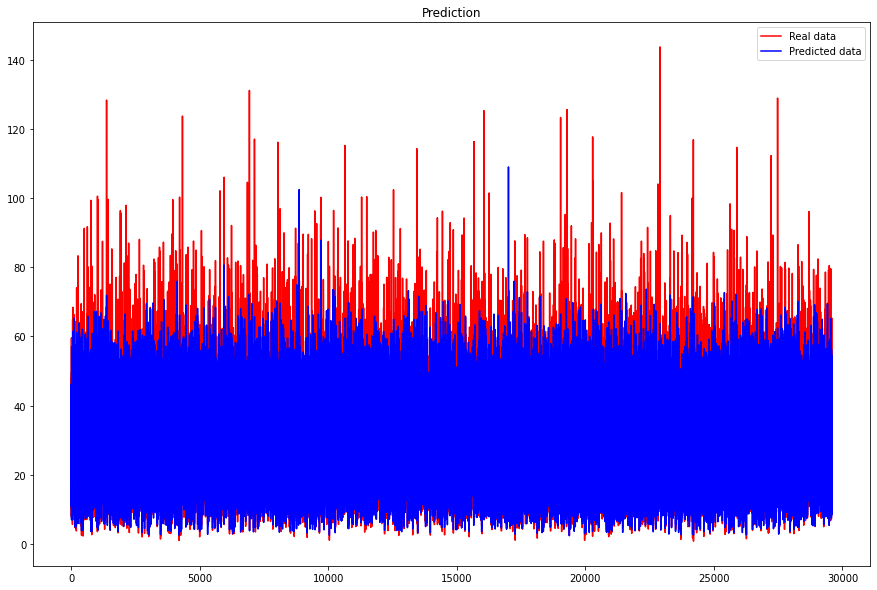

In [141]:
plt.plot(y_test.to_numpy(), color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [142]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.5241331449402304
Mean Squared Error: 60.805216076852474
Root Mean Squared Error: 7.79776994254463


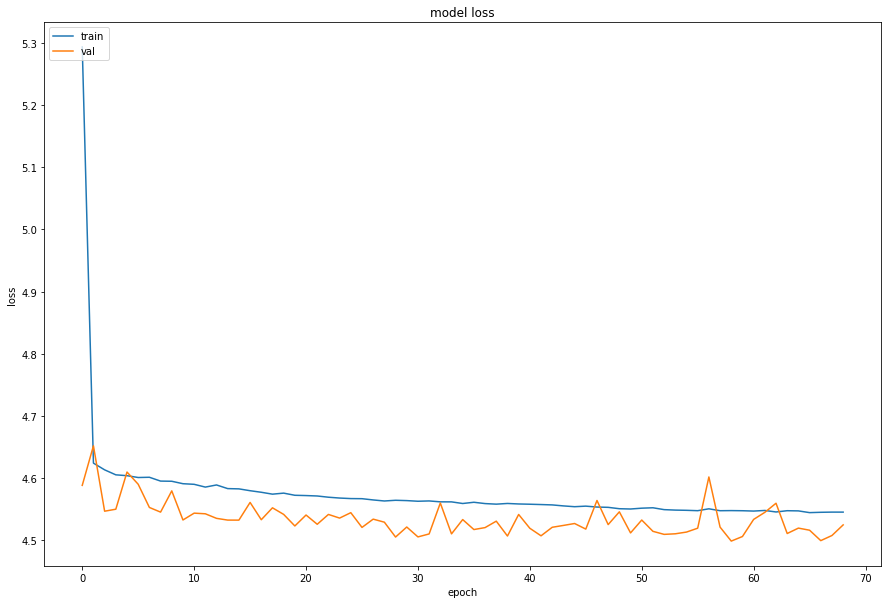

In [143]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [144]:
y_test

138640     8.174016
84933     19.886165
20224     47.614875
57593     40.034584
142358    36.934130
            ...    
12501     50.422163
84302     30.092474
61799     30.892472
92993     25.621937
89485      9.536235
Name: ya_dur, Length: 29599, dtype: float64

In [145]:
y_pred.flatten()

array([10.848913, 22.129646, 43.361267, ..., 35.10698 , 26.553143,
        8.924616], dtype=float32)

In [146]:
test = dataset.iloc[y_test.index]

In [147]:
test["error"] = test["ya_dur"] - y_pred.flatten()
test["osrm_error"] = test["ya_dur"] - test["osrm_dur"]

<ipython-input-147-b78cbc926ff7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["error"] = test["ya_dur"] - y_pred.flatten()
<ipython-input-147-b78cbc926ff7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["osrm_error"] = test["ya_dur"] - test["osrm_dur"]


In [148]:
sklearn.metrics.mean_absolute_error(test["ya_dur"], test["osrm_dur"])

8.101797943971254

In [149]:
sklearn.metrics.mean_absolute_error(test["ya_dur"], y_pred)

4.5241331449402304

In [187]:
test = dataset.iloc[y_test.index]
test["error"] = abs(test["ya_dur"] - y_pred.flatten()) / test["ya_dur"]
std = np.std(test.osrm_error)
mean = np.mean(test.osrm_error)
cals, vals = np.histogram(test.osrm_error, bins = 200)
plt.hist(test.osrm_error, bins = 200)
# plt.ylim(0, max(cals)*1.1)
# plt.xlim(0, std*3 + mean)
plt.title(f"OSRM error: mean={mean:.2f}, std={std:.2f}")
plt.xlabel("OSRM Error for route, min [ETA]")
_ = plt.ylabel("Count")
print(f"Mean: {mean}, std: {std}")test["osrm_error"] = abs(test["ya_dur"] - test["osrm_dur"]) / test["ya_dur"]

<ipython-input-187-d7b896b3b092>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["error"] = abs(test["ya_dur"] - y_pred.flatten()) / test["ya_dur"]
<ipython-input-187-d7b896b3b092>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["osrm_error"] = abs(test["ya_dur"] - test["osrm_dur"]) / test["ya_dur"]


Mean: 0.2465099400639905, std: 0.15375539609819627


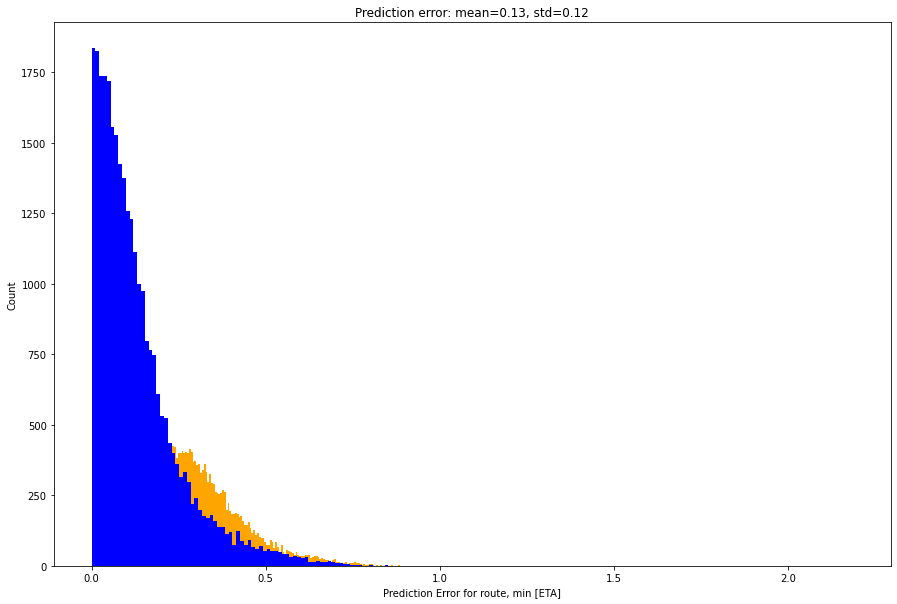

In [204]:
std = np.std(test.osrm_error)
mean = np.mean(test.osrm_error)
cals, vals = np.histogram(test.osrm_error, bins = 200)
plt.hist(test.osrm_error, bins = 200, color="orange")
# plt.ylim(0, max(cals)*1.1)
# plt.xlim(0, std*3 + mean)
plt.title(f"OSRM error: mean={mean:.2f}, std={std:.2f}")
plt.xlabel("OSRM Error for route, min [ETA]")
_ = plt.ylabel("Count")
print(f"Mean: {mean}, std: {std}")

std = np.std(test.error)
mean = np.mean(test.error)
cals, vals = np.histogram(test.error, bins = 200)
plt.hist(test.error, bins = 200, color="blue")
# plt.ylim(0, max(cals)*1.1)
# plt.xlim(0, std*3 + mean)
plt.title(f"Prediction error: mean={mean:.2f}, std={std:.2f}")
plt.xlabel("Prediction Error for route, min [ETA]")
_ = plt.ylabel("Count")

plt.show()

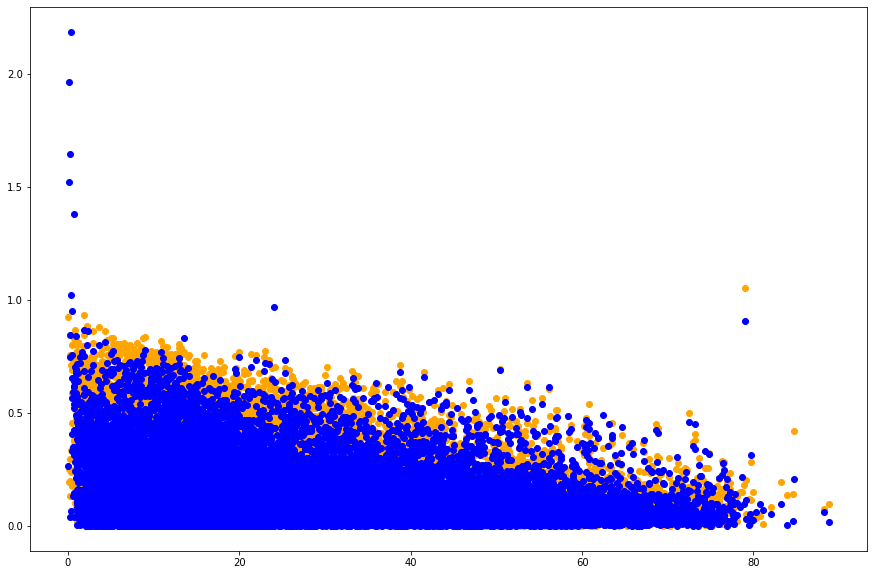

In [205]:
plt.scatter(test.dist, test.osrm_error, color="orange")
plt.scatter(test.dist, test.error, color="blue")
plt.show()

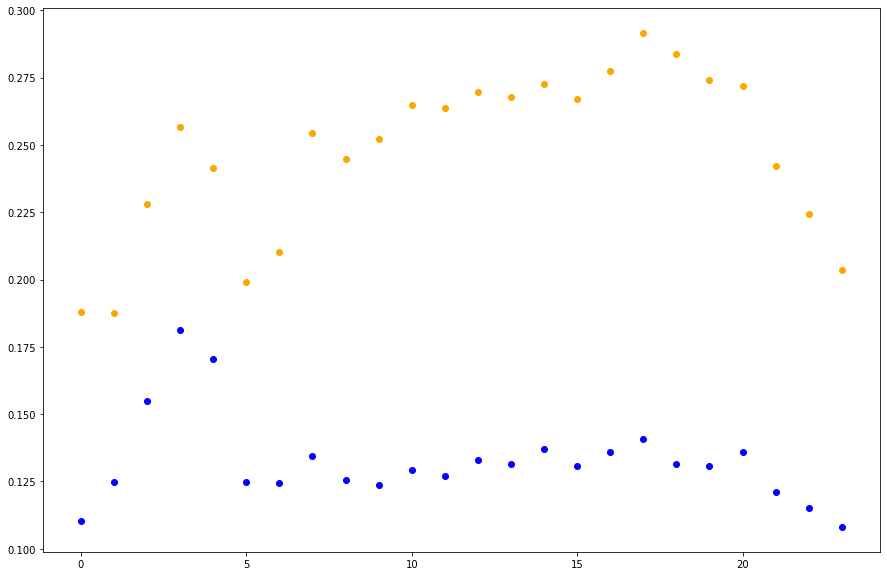

In [206]:
plt.scatter(range(0,24), test.groupby(["hour"]).mean().osrm_error, color="orange")
plt.scatter(range(0,24), test.groupby(["hour"]).mean().error, color="blue")
plt.show()